In [2]:
# 0) Setup & Imports
import warnings, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7,5)
RANDOM_STATE = 42
DATA_PATH = Path("dashboard/main_data.csv")

In [3]:
# 1) Load Data & Quick Peek
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head(3))

# Pastikan kolom yang dipakai tersedia
required = ["season", "weathersit_y", "hr", "month", "cnt_y"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Kolom wajib hilang: {missing}. Periksa nama kolom di CSV.")

(17379, 19)


,dteday,season,weathersit_x,cnt_x,weekday_x,is_weekend_x,week,month,year,Level_deman_x,weather_label_x,hr,weathersit_y,cnt_y,weekday_y,is_weekend_y,hour_block,Level_deman_y,weather_label_y
0,2011-01-01,1,2,985,Saturday,True,52,1,2011,Low,Berawan,0,1,16,Saturday,True,Night (22-05),Low,Cerah
1,2011-01-01,1,2,985,Saturday,True,52,1,2011,Low,Berawan,1,1,40,Saturday,True,Night (22-05),Low,Cerah
2,2011-01-01,1,2,985,Saturday,True,52,1,2011,Low,Berawan,2,1,32,Saturday,True,Night (22-05),Low,Cerah


In [4]:
# 2) Data Cleaning (NA, tipe data, duplikat)

# Cast tipe numerik jika perlu
for col in ["season", "weathersit_y", "hr", "month", "cnt_y"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Cek & drop NA pada kolom penting
before = len(df)
df = df.dropna(subset=["season","weathersit_y","hr","month","cnt_y"]).copy()
after = len(df)
print(f"Dropping NA: {before - after} baris dihapus.")

# Optional: hapus duplikat jika ada
dup = df.duplicated(subset=["season","weathersit_y","hr","month","cnt_y"]).sum()
if dup > 0:
    df = df.drop_duplicates(subset=["season","weathersit_y","hr","month","cnt_y"]).copy()
    print(f"Menghapus duplikat: {dup} baris.")


Dropping NA: 0 baris dihapus.
Menghapus duplikat: 1967 baris.


In [5]:
# 3) Pilih Fitur & Standardisasi
features = ["season", "weathersit_y", "hr", "month"]   # fitur pemicu pola
target   = "cnt_y"                                     # jumlah penyewaan (untuk profiling, TIDAK di-scale)

X = df[features].copy()
y = df[target].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Fitur yang digunakan:", features)


Fitur yang digunakan: ['season', 'weathersit_y', 'hr', 'month']


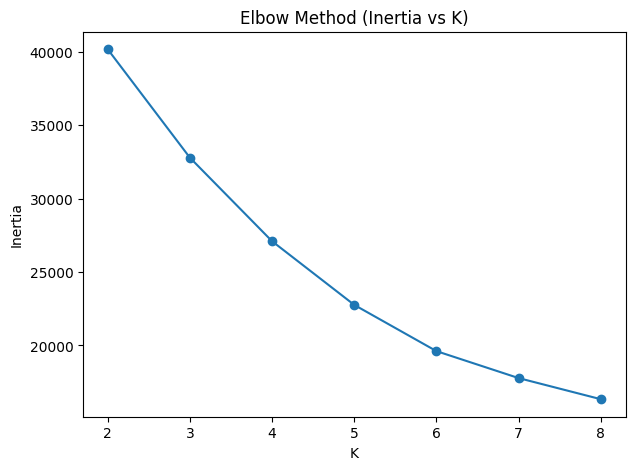

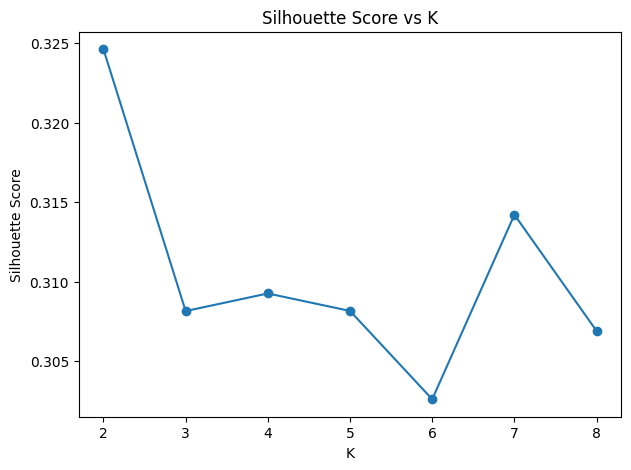

[(2, 40185.99720924827, 0.32462600350748844),
 (3, 32795.675739896586, 0.3081529252182863),
 (4, 27099.296213721515, 0.3092593734921276),
 (5, 22759.53738117359, 0.30816029412063617),
 (6, 19608.769424508046, 0.30260542742976193),
 (7, 17771.48378516978, 0.31421145119996363),
 (8, 16331.948541053865, 0.30689552275552084)]

In [6]:
# 4) Cari Jumlah Cluster Optimal (Elbow & Silhouette)
K_RANGE = range(2, 9)  # 2..8
inertias, silhouettes = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot Elbow
plt.figure()
plt.plot(list(K_RANGE), inertias, marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette
plt.figure()
plt.plot(list(K_RANGE), silhouettes, marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

list(zip(K_RANGE, inertias, silhouettes))


In [7]:
# 5) Fit KMeans (pilih K final)
K_FINAL = 3  # <-- ubah sesuai hasil Elbow/Silhouette kamu
kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=20)
df["cluster"] = kmeans.fit_predict(X_scaled)

print("Centroid (di ruang fitur terstandardisasi):")
print(pd.DataFrame(kmeans.cluster_centers_, columns=features))
df["cluster"].value_counts().sort_index()


Centroid (di ruang fitur terstandardisasi):
     season  weathersit_y        hr     month
0  0.626288      1.338700 -0.082343  0.723593
1 -0.889030     -0.109617  0.014200 -0.938974
2  0.742434     -0.692352  0.033095  0.745540


cluster
0    3309
1    6778
2    5325
Name: count, dtype: int64

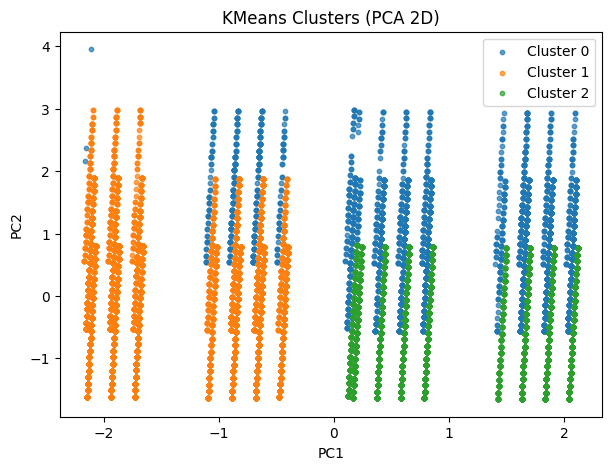

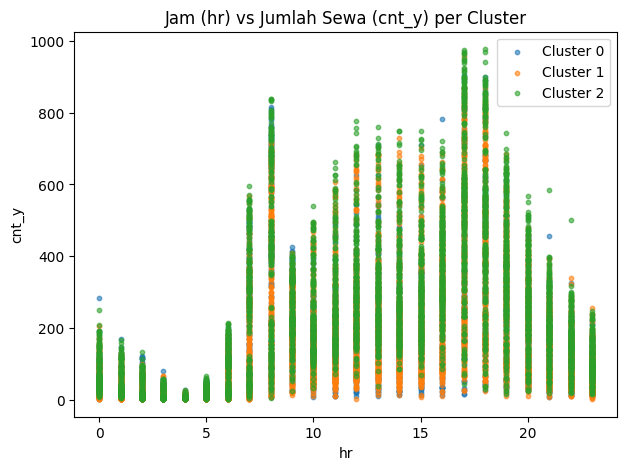

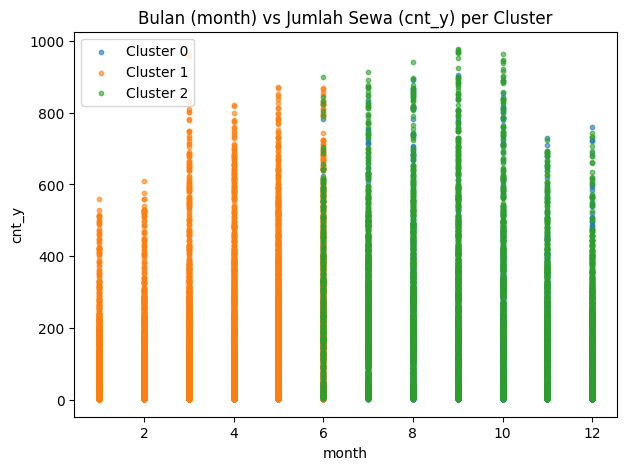

In [8]:
# 6) Visualisasi 2D (PCA) & Scatter Analitik

# PCA untuk proyeksi 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df["_pc1"], df["_pc2"] = X_pca[:,0], X_pca[:,1]

plt.figure()
for c in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == c]
    plt.scatter(subset["_pc1"], subset["_pc2"], s=10, alpha=0.7, label=f"Cluster {c}")
plt.title("KMeans Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

# Scatter hubungan variabel penting (contoh: hr vs cnt_y)
plt.figure()
for c in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == c]
    plt.scatter(subset["hr"], subset["cnt_y"], s=10, alpha=0.6, label=f"Cluster {c}")
plt.title("Jam (hr) vs Jumlah Sewa (cnt_y) per Cluster")
plt.xlabel("hr")
plt.ylabel("cnt_y")
plt.legend()
plt.show()

# Scatter lain: month vs cnt_y
plt.figure()
for c in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == c]
    plt.scatter(subset["month"], subset["cnt_y"], s=10, alpha=0.6, label=f"Cluster {c}")
plt.title("Bulan (month) vs Jumlah Sewa (cnt_y) per Cluster")
plt.xlabel("month")
plt.ylabel("cnt_y")
plt.legend()
plt.show()


In [9]:
# 7) Profiling & Ringkasan Tiap Cluster

# Ringkasan nilai rata-rata di ruang asli (bukan scaled)
profile_means = df.groupby("cluster")[features + [target]].mean().round(2)

# Tambahkan metrik tambahan yang berguna
profile_more = df.groupby("cluster").agg(
    n=("cluster", "count"),
    cnt_median=("cnt_y", "median"),
    cnt_p25=("cnt_y", lambda s: np.percentile(s, 25)),
    cnt_p75=("cnt_y", lambda s: np.percentile(s, 75)),
).round(2)

# Urutkan cluster berdasarkan rata-rata cnt_y (tinggi ke rendah)
order = profile_means[target].sort_values(ascending=False).index.tolist()
profile_means = profile_means.loc[order]
profile_more  = profile_more.loc[order]

print("\n=== Rata-rata fitur per cluster (diurutkan dari demand tertinggi) ===")
display(profile_means)

print("\n=== Metrik tambahan per cluster ===")
display(profile_more)

# Crosstab opsional: distribusi season & weather per cluster
ct_season = pd.crosstab(df["cluster"], df["season"])
ct_weather = pd.crosstab(df["cluster"], df["weathersit_y"])
print("\nDistribusi Season per Cluster:")
display(ct_season)
print("\nDistribusi Weathersit per Cluster:")
display(ct_weather)



=== Rata-rata fitur per cluster (diurutkan dari demand tertinggi) ===


,season,weathersit_y,hr,month,cnt_y
cluster,,,,,
2,3.33,1.00,12.35,9.13,244.78
0,3.20,2.33,11.58,9.05,184.89
1,1.53,1.38,12.22,3.35,184.43



=== Metrik tambahan per cluster ===


,n,cnt_median,cnt_p25,cnt_p75
cluster,,,,
2,5325,205.0,92.0,351.0
0,3309,144.0,45.0,271.0
1,6778,135.0,52.0,267.0



Distribusi Season per Cluster:


season,1,2,3,4
cluster,,,,
0,227,392,1182,1508
1,3203,3575,0,0
2,259,0,2800,2266



Distribusi Weathersit per Cluster:


weathersit_y,1,2,3,4
cluster,,,,
0,0,2231,1075,3
1,4493,1990,295,0
2,5325,0,0,0


In [ ]:
# 8) Simpan Hasil (opsional untuk lampiran UTS)
out = df[["dteday","season","weathersit_y","hr","month","cnt_y","cluster"]].copy() if "dteday" in df.columns \
     else df[["season","weathersit_y","hr","month","cnt_y","cluster"]].copy()
out_path = Path("./clustered_bike_rentals.csv")
out.to_csv(out_path, index=False)
out_path